In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets,transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### MNIST - getting data

In [2]:
is_cuda=False
if torch.cuda.is_available():
    is_cuda = True

In [3]:
transformation = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])

#下载训练集，同时进行数据处理
train_dataset = datasets.MNIST('data/',train=True,transform=transformation,download=True)
#下载测试集
test_dataset = datasets.MNIST('data/',train=False,transform=transformation,download=True)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=True)

In [4]:
sample_data = next(iter(train_loader))

In [5]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((std * image) + mean)
    plt.imshow(image,cmap='gray') 

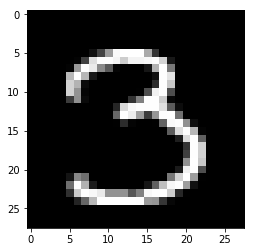

In [6]:
plot_img(sample_data[0][2])

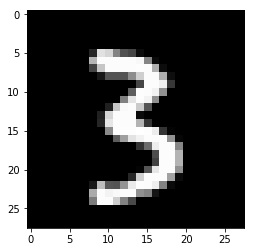

In [7]:
plot_img(sample_data[0][1])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        #x = F.dropout(x,p=0.1, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

In [9]:
model = Net()
if is_cuda:
    model.cuda()

In [10]:
optimizer = optim.SGD(model.parameters(),lr=0.01)

In [11]:
data,target = next(iter(train_loader))

In [12]:
output = model(Variable(data.cuda()))

In [13]:
output.size()

torch.Size([32, 10])

In [14]:
target.size()

torch.Size([32])

In [16]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval() #evaluation mode
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data,target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)#负对数似然损失
        
        running_loss += loss.item()
        preds = output.max(dim=1,keepdim=True)[1] #返回最大值的索引张量
        running_correct += torch.sum(preds.eq(target.data.view_as(preds))).item()# View this tensor as the same as other
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [17]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is 0.022 and training accuracy is 46501/60000      77.5
validation loss is 0.005 and validation accuracy is 9511/10000     95.11
training loss is 0.0067 and training accuracy is 56254/60000     93.76
validation loss is 0.0032 and validation accuracy is 9676/10000     96.76
training loss is 0.0051 and training accuracy is 57177/60000      95.3
validation loss is 0.0024 and validation accuracy is 9766/10000     97.66
training loss is 0.0042 and training accuracy is 57599/60000      96.0
validation loss is 0.0022 and validation accuracy is 9772/10000     97.72
training loss is 0.0037 and training accuracy is 57874/60000     96.46
validation loss is 0.0018 and validation accuracy is 9826/10000     98.26
training loss is 0.0033 and training accuracy is 58131/60000     96.89
validation loss is 0.0016 and validation accuracy is 9836/10000     98.36
training loss is 0.0031 and training accuracy is 58247/60000     97.08
validation loss is 0.0015 and validation accuracy is 9853/100

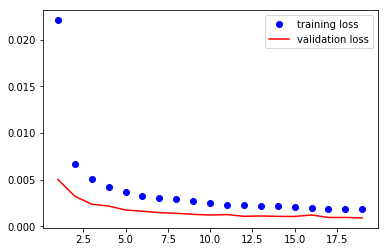

In [18]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

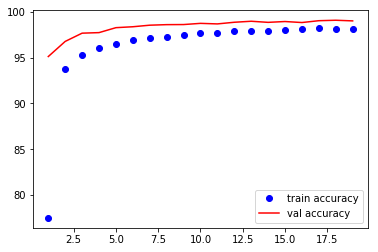

In [19]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()

## Understanding 1d convolutions

In [20]:
conv = nn.Conv1d(1,1,3,bias=False) #注意这里是conv1d

In [21]:
conv.weight

Parameter containing:
tensor([[[ 0.3701, -0.5543,  0.5287]]], requires_grad=True)

In [22]:
sample = torch.randn(1,1,7)

In [23]:
sample

tensor([[[ 0.3223, -0.6033,  0.4736,  0.5550, -2.3597,  1.4966, -0.1800]]])

In [24]:
conv(Variable(sample))

tensor([[[ 0.7041, -0.1923, -1.3800,  2.3047, -1.7981]]], grad_fn=<SqueezeBackward1>)

### Understand how padding works in Conv1d

In [25]:
conv = nn.Conv1d(1,1,3,padding=2,bias=False)
conv.weight

Parameter containing:
tensor([[[-0.2924, -0.0325,  0.4495]]], requires_grad=True)

In [26]:
sample = torch.randn(1,1,7)
sample

tensor([[[ 1.4907, -0.1798, -0.2226,  1.5817,  0.4148,  0.3044, -1.2825]]])

In [27]:
conv(Variable(sample))

tensor([[[ 0.6701, -0.1292, -0.5301,  0.7708,  0.2002, -0.3391, -0.7077,
          -0.0473,  0.3750]]], grad_fn=<SqueezeBackward1>)